In [1]:
import warnings
from dataclasses import dataclass, field
from functools import partial

import aeolus
import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import (
    last_n_day_mean,
    spatial_mean,
    zonal_mean,
)
from aeolus.coord import interp_cube_from_height_to_pressure_levels, regrid_3d
from aeolus.lfric import add_equally_spaced_height_coord, fix_time_coord, load_lfric_raw
from aeolus.model import lfric, um
from aeolus.plot import figsave, tex2cf_units, unit_format
from common import EXPERIMENTS

warnings.filterwarnings("ignore", category=UserWarning, module="iris")
iris.FUTURE.date_microseconds = True

plt.rcParams["mathtext.default"] = "regular"

In [2]:
exp_label = "camembert_case3_gj1214b"

In [3]:
from aeolus.coord import ensure_bounds
from iris.exceptions import CoordinateNotFoundError as CoNotFound
from iris.util import promote_aux_coord_to_dim_coord


def replace_z_coord(cube, remove_level_coord=False, inplace=False, model=lfric):
    """
    Replace levels coordinate with level_height.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Copy of the input cube with a new vertical coordinate.
    """
    if inplace:
        new_cube = cube
    else:
        new_cube = cube.copy()
    promote_aux_coord_to_dim_coord(new_cube, model.z)
    # Reset bounds for the new z coordinate
    new_cube.coord(model.z).bounds = None
    ensure_bounds(new_cube, coords=[model.z])
    # Remove the old levels coordinate
    if remove_level_coord:
        lev_coords = [
            i.name() for i in new_cube.coords() if i.name().endswith("_levels")
        ]
        for coord in lev_coords:
            try:
                new_cube.remove_coord(coord)
            except CoNotFound:
                pass
    if not inplace:
        return new_cube

In [4]:
def combi_callback(cube, field, filename, model_top_height):
    """Callback function to apply multiple transformations."""
    fix_time_coord(cube, field, filename)
    add_equally_spaced_height_coord(
        cube, field, filename, model_top_height=model_top_height
    )
    try:
        replace_z_coord(cube, inplace=True, remove_level_coord=True, model=lfric)
    except iris.exceptions.CoordinateNotFoundError:
        pass


In [5]:
@dataclass
class BenchModel:
    """Model details."""

    title: str
    kw_plt: dict = field(default_factory=dict)
    model: aeolus.model.base.Model = lfric


MODELS = {
    "lfric": BenchModel(
        model=lfric,
        title="LFRic",
        kw_plt={
            "linestyle": "-",
            "linewidth": 1.25,
        },
    ),
    "um": BenchModel(
        model=um,
        title="UM",
        kw_plt={
            "linestyle": "--",
            "linewidth": 0.75,
            "dash_capstyle": "round",
        },
    ),
}

In [6]:
ds_all = {}

model_name = "lfric"
fnames = sorted(
    (paths.data_work / model_name / exp_label).glob("lfric_diag_latlon*.nc")
)[-100:]
ds_all[model_name] = load_lfric_raw(
    fnames, callback=partial(combi_callback, model_top_height=4e6)
)
print(ds_all[model_name])
print()

model_name = "um"
fnames = paths.data_work / model_name / exp_label / "UM-Case3-GJ1214b.nc"
ds_all[model_name] = iris.load(fnames)
print(ds_all[model_name])

0: air_pressure / (Pa)                 (time: 100; level_height: 67; latitude: 90; longitude: 144)
1: air_temperature / (K)               (time: 100; level_height: 67; latitude: 90; longitude: 144)
2: eastward_wind / (ms-1)              (time: 100; level_height: 66; latitude: 90; longitude: 144)
3: longwave_heating_rate / (K s-1)     (time: 100; level_height: 67; latitude: 90; longitude: 144)
4: northward_wind / (ms-1)             (time: 100; level_height: 66; latitude: 90; longitude: 144)
5: shortwave_heating_rate / (K s-1)    (time: 100; level_height: 67; latitude: 90; longitude: 144)
6: toa_direct_shortwave_flux / (W m-2) (time: 100; latitude: 90; longitude: 144)
7: toa_upward_longwave_flux / (W m-2)  (time: 100; latitude: 90; longitude: 144)
8: toa_upward_shortwave_flux / (W m-2) (time: 100; latitude: 90; longitude: 144)
9: upward_air_velocity / (ms-1)        (time: 100; level_height: 66; latitude: 90; longitude: 144)

0: air_pressure / (Pa)                 (time: 23; level_height:

In [7]:
_ds = iris.cube.CubeList()
for cube in ds_all["lfric"]:
    if lfric.z in [i.name() for i in cube.dim_coords]:
        _ds.append(
            regrid_3d(cube, ds_all["lfric"].extract_cube("air_pressure"), model=lfric)
        )
ds_all["lfric"] = _ds


ds_all["um"].extract_cube(
    "tendency_of_air_temperature_due_to_shortwave_heating"
).rename("shortwave_heating_rate")

In [8]:
@dataclass
class Diag:
    """Diagnostics to be plotted."""

    title: str
    units: str
    recipe: callable
    kw_plt: dict = field(default_factory=dict)

## Zonal-mean plots

In [9]:
ZMDIAGS = {
    "temp": Diag(
        title="Air Temperature",
        units="$K$",
        recipe=lambda cl: cl.extract_cube("air_temperature"),
        kw_plt={"cmap": "plasma", "levels": np.arange(400, 1200, 100)},
    ),
    "u": Diag(
        title="Eastward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl: cl.extract_cube("eastward_wind"),
        kw_plt={"cmap": "inferno", "vmin": -300, "vmax": 2100},
    ),
    "w": Diag(
        title="Upward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl: cl.extract_cube("upward_air_velocity"),
        kw_plt={"cmap": "PuOr_r", "vmin": -10, "vmax": 10},
    ),
    "dt_sw": Diag(
        title="SW Heating Rate",
        units="$K$ $day^{-1}$",
        recipe=lambda cl: cl.extract_cube("shortwave_heating_rate"),
        kw_plt={"cmap": "magma", "vmin": 0, "vmax": 1000},
    ),
}

Saved to ../figures/drafts/lfric_um__camembert_case3_gj1214b__temp_zm.pdf
Size: 61.5 KB


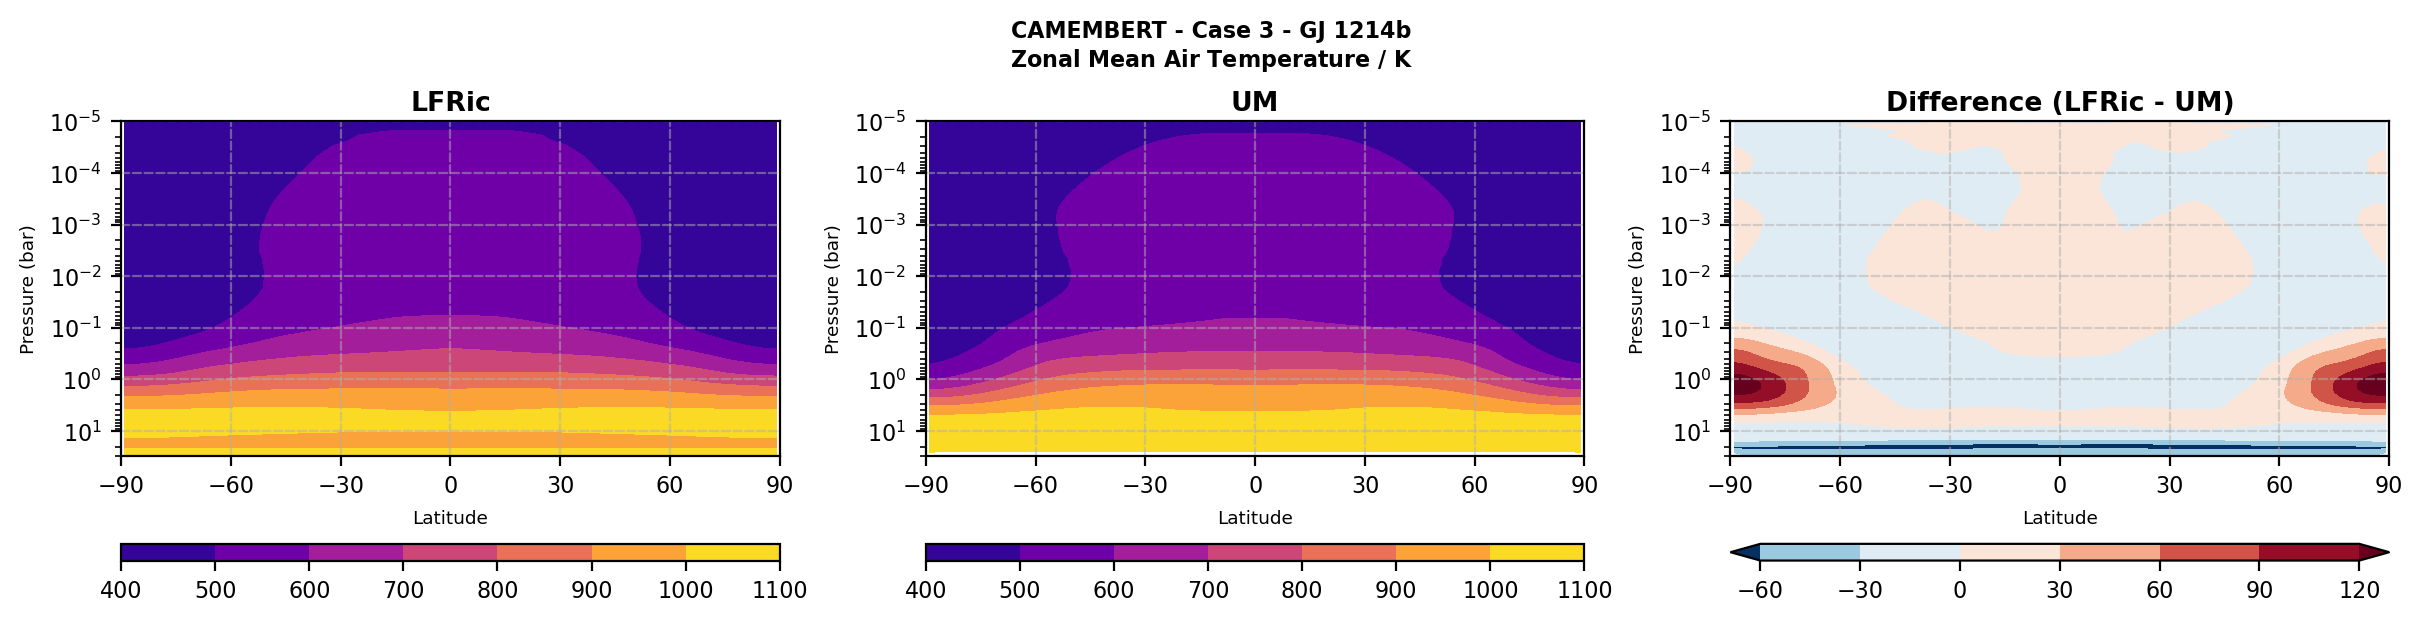

In [10]:
diag_key = "temp"
collapse_func = lambda cube: last_n_day_mean(zonal_mean(cube), 1000)  # noqa: E731

fig = plt.figure(figsize=(12, 3), layout="constrained")

fig.suptitle(
    "\n".join(
        [
            f"{EXPERIMENTS[exp_label].title}",
            f"Zonal Mean {ZMDIAGS[diag_key].title} / {ZMDIAGS[diag_key].units}",
        ]
    ),
    fontsize="medium",
)

axd = fig.subplot_mosaic(
    [
        ["lfric", "um", "diff"],
        ["cbar_lfric", "cbar_um", "cbar_diff"],
    ],
    gridspec_kw={"height_ratios": [1, 0.05]},
)

for ax in axd.values():
    if not ax.get_label().startswith("cbar_"):
        ax.set_xlabel("Latitude")
        ax.set_ylabel("Pressure (bar)")
        ax.set_yscale("log")
        ax.set_ylim(3e1, 1e-5)
        ax.set_xlim(-90, 90)
        ax.set_xticks(np.arange(-90, 91, 30))
        ax.grid(True, linestyle="--", alpha=0.5, dash_capstyle="round")

two_cubes = []
for model_name in MODELS:
    axd[model_name].set_title(MODELS[model_name].title)
    pres_prof = last_n_day_mean(
        spatial_mean(ds_all[model_name].extract_cube("air_pressure")),
        1000,
        model=MODELS[model_name].model,
    )
    pres_prof.convert_units("bar")
    cube = collapse_func(ZMDIAGS[diag_key].recipe(ds_all[model_name]))
    cube.convert_units(tex2cf_units(ZMDIAGS[diag_key].units))
    two_cubes.append(cube)
    cntr = axd[model_name].contourf(
        cube.coord("latitude").points,
        pres_prof.data,
        cube.data,
        **ZMDIAGS[diag_key].kw_plt,
    )
    fig.colorbar(cntr, cax=axd[f"cbar_{model_name}"], orientation="horizontal")


iris.util.equalise_attributes(two_cubes)
two_cubes[1].units = two_cubes[0].units
two_cubes[1].coord("latitude").var_name = "latitude"
two_cubes[1].coord("latitude").long_name = None
two_cubes[1].coord("latitude").coord_system = (
    two_cubes[0].coord("latitude").coord_system
)

diff_cube = two_cubes[0] - two_cubes[1]
axd["diff"].set_title(f"Difference ({MODELS['lfric'].title} - {MODELS['um'].title})")
cntr = axd["diff"].contourf(
    diff_cube.coord("latitude").points,
    pres_prof.data,
    diff_cube.data,
    norm=mcol.CenteredNorm(0),
    cmap="RdBu_r",
    extend="both",
)
cbar = fig.colorbar(cntr, cax=axd["cbar_diff"], orientation="horizontal")


figsave(
    fig,
    paths.drafts / f"{'_'.join(MODELS)}__{exp_label}__{diag_key}_zm",
)


## Equatorial cross-sections

In [11]:
EQDIAGS = {
    "temp": Diag(
        title="Air Temperature",
        units="$K$",
        recipe=lambda cl: cl.extract_cube("air_temperature"),
        kw_plt={"cmap": "plasma", "levels": np.arange(400, 1200, 100)},
    ),
    "u": Diag(
        title="Eastward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl: cl.extract_cube("eastward_wind"),
        kw_plt={"cmap": "inferno", "vmin": -300, "vmax": 2100},
    ),
    "w": Diag(
        title="Upward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl: cl.extract_cube("upward_air_velocity"),
        kw_plt={"cmap": "PuOr_r", "vmin": -10, "vmax": 10},
    ),
    "dt_sw": Diag(
        title="SW Heating Rate",
        units="$K$ $day^{-1}$",
        recipe=lambda cl: cl.extract_cube("shortwave_heating_rate"),
        kw_plt={"cmap": "magma", "vmin": 0, "vmax": 2400},
    ),
}

Saved to ../figures/drafts/lfric_um__camembert_case3_gj1214b__w_eq.pdf
Size: 131.0 KB


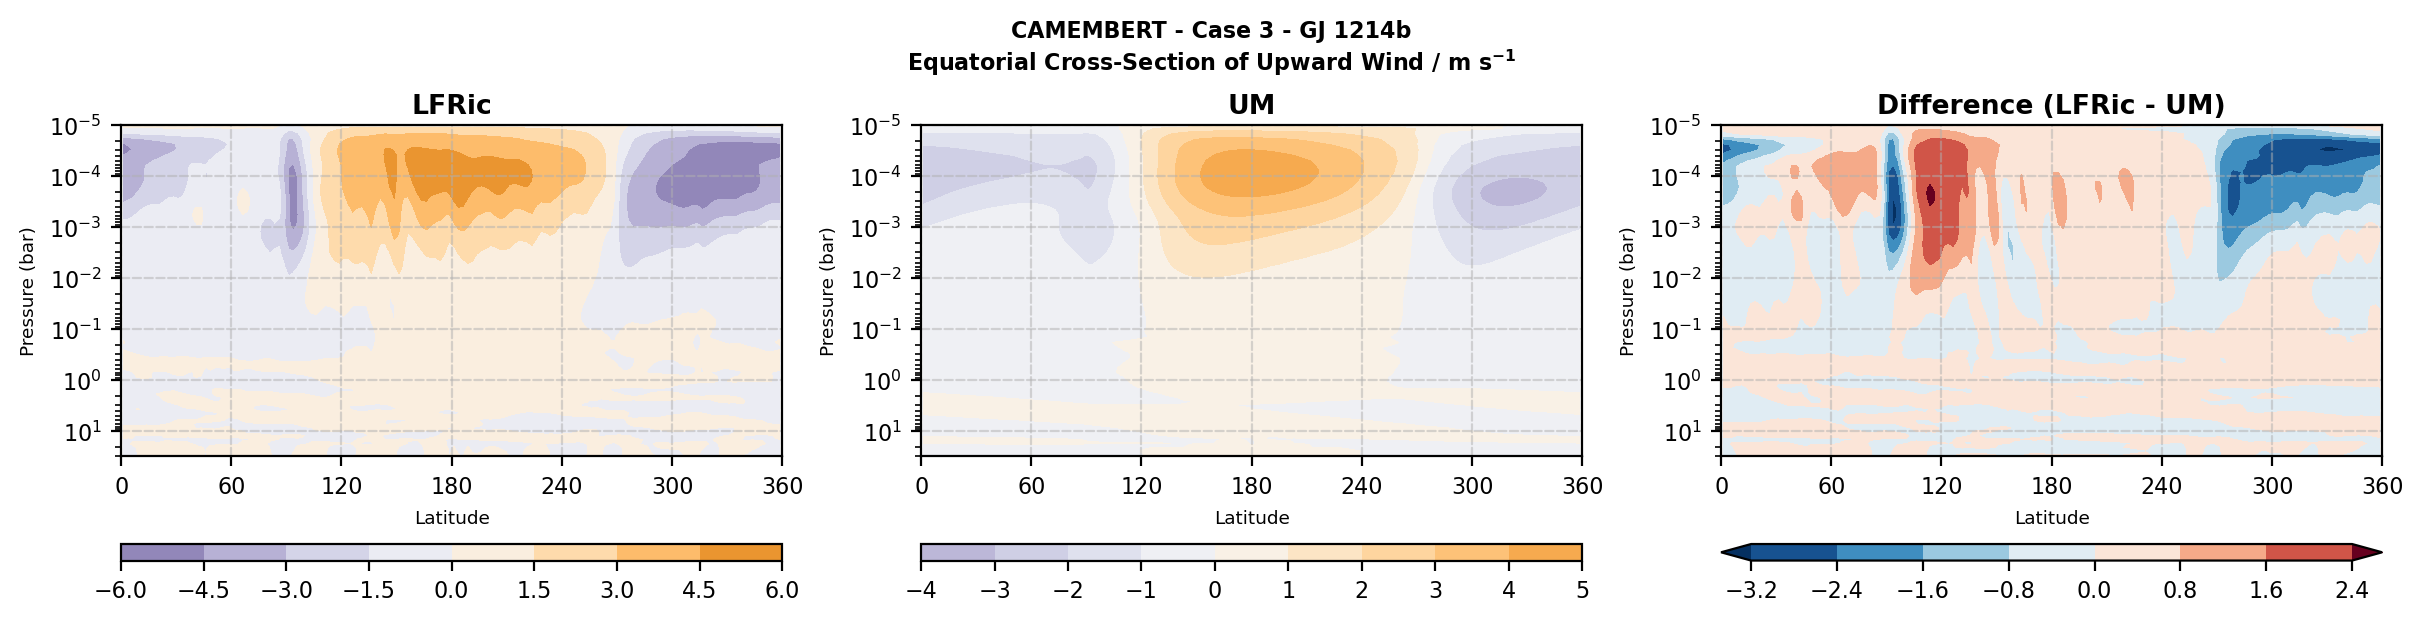

In [12]:
diag_key = "w"
collapse_func = lambda cube: last_n_day_mean(
    cube.interpolate([("latitude", 0)], iris.analysis.Linear()), 1000
)  # noqa: E731

fig = plt.figure(figsize=(12, 3), layout="constrained")

fig.suptitle(
    "\n".join(
        [
            f"{EXPERIMENTS[exp_label].title}",
            f"Equatorial Cross-Section of {EQDIAGS[diag_key].title} / {EQDIAGS[diag_key].units}",
        ]
    ),
    fontsize="medium",
)

axd = fig.subplot_mosaic(
    [
        ["lfric", "um", "diff"],
        ["cbar_lfric", "cbar_um", "cbar_diff"],
    ],
    gridspec_kw={"height_ratios": [1, 0.05]},
)

for ax in axd.values():
    if not ax.get_label().startswith("cbar_"):
        ax.set_xlabel("Latitude")
        ax.set_ylabel("Pressure (bar)")
        ax.set_yscale("log")
        ax.set_ylim(3e1, 1e-5)
        ax.set_xlim(0, 360)
        ax.set_xticks(np.arange(0, 361, 60))
        ax.grid(True, linestyle="--", alpha=0.5, dash_capstyle="round")

two_cubes = []
for model_name in MODELS:
    axd[model_name].set_title(MODELS[model_name].title)
    pres_prof = last_n_day_mean(
        spatial_mean(ds_all[model_name].extract_cube("air_pressure")),
        1000,
        model=MODELS[model_name].model,
    )
    pres_prof.convert_units("bar")
    cube = collapse_func(EQDIAGS[diag_key].recipe(ds_all[model_name]))
    if cube.units == "ms-1":
        cube.units = "m s-1"
    cube.convert_units(tex2cf_units(EQDIAGS[diag_key].units))
    two_cubes.append(cube)
    cntr = axd[model_name].contourf(
        cube.coord("longitude").points,
        pres_prof.data,
        cube.data,
        **EQDIAGS[diag_key].kw_plt,
    )
    fig.colorbar(cntr, cax=axd[f"cbar_{model_name}"], orientation="horizontal")


iris.util.equalise_attributes(two_cubes)
two_cubes[1].units = two_cubes[0].units
two_cubes[1].coord("longitude").var_name = "longitude"
two_cubes[1].coord("longitude").long_name = None
two_cubes[1].coord("longitude").coord_system = (
    two_cubes[0].coord("longitude").coord_system
)

diff_cube = two_cubes[0] - two_cubes[1]
axd["diff"].set_title(f"Difference ({MODELS['lfric'].title} - {MODELS['um'].title})")
cntr = axd["diff"].contourf(
    diff_cube.coord("longitude").points,
    pres_prof.data,
    diff_cube.data,
    norm=mcol.CenteredNorm(0),
    cmap="RdBu_r",
    extend="both",
)
cbar = fig.colorbar(cntr, cax=axd["cbar_diff"], orientation="horizontal")


figsave(
    fig,
    paths.drafts / f"{'_'.join(MODELS)}__{exp_label}__{diag_key}_eq",
)


## Longitude-latitude maps

In [13]:
LLDIAGS = {
    "temp": Diag(
        title="Air Temperature",
        units="$K$",
        recipe=lambda cl: cl.extract_cube("air_temperature"),
        kw_plt={"cmap": "plasma", "vmin": 400, "vmax": 600},
    ),
    "u": Diag(
        title="Eastward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl: cl.extract_cube("eastward_wind"),
        kw_plt={"cmap": "inferno", "vmin": -300, "vmax": 2100},
    ),
    "w": Diag(
        title="Upward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl: cl.extract_cube("upward_air_velocity"),
        kw_plt={"cmap": "PuOr_r", "vmin": -30, "vmax": 30},
    ),
    "dt_sw": Diag(
        title="SW Heating Rate",
        units="$K$ $day^{-1}$",
        recipe=lambda cl: cl.extract_cube("shortwave_heating_rate"),
        kw_plt={"cmap": "magma", "vmin": 0, "vmax": 900},
    ),
}

Saved to ../figures/drafts/lfric_um__camembert_case3_gj1214b__temp_ll_10pa.pdf
Size: 164.9 KB


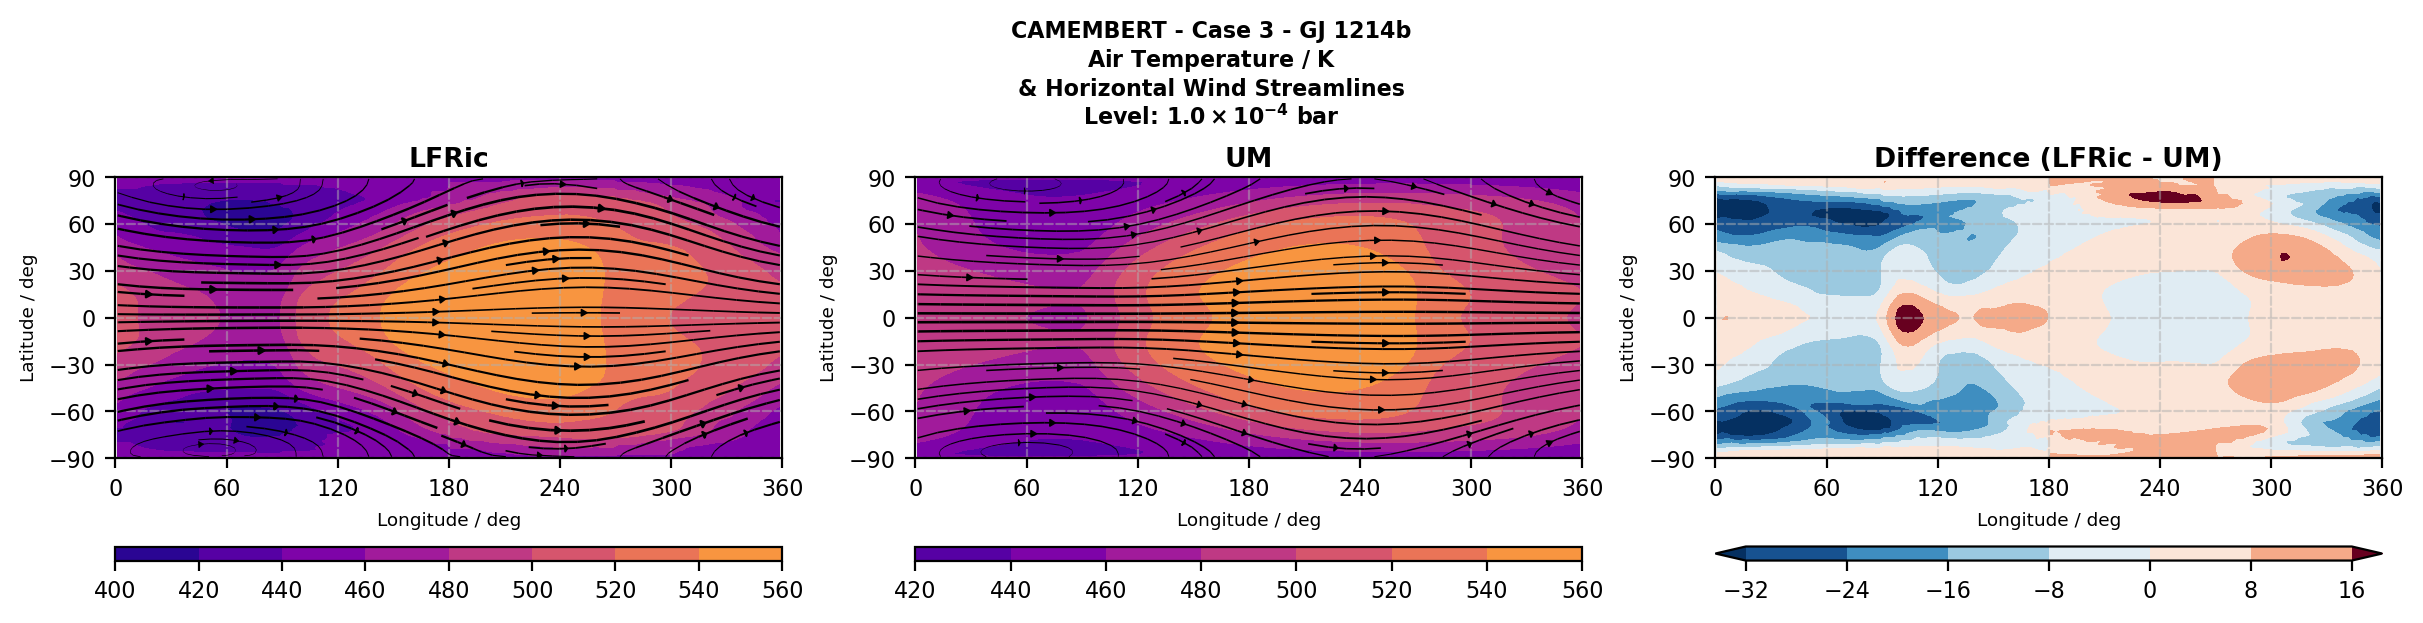

In [14]:
diag_key = "temp"
LEVEL = 10
overlay_stream = True

collapse_func = lambda cube, p_cube, levels, model: last_n_day_mean(
    interp_cube_from_height_to_pressure_levels(
        cube, p_cube, levels=levels, model=model
    ),
    1000,
)  # noqa: E731

fig = plt.figure(figsize=(12, 3), layout="constrained")

axd = fig.subplot_mosaic(
    [
        ["lfric", "um", "diff"],
        ["cbar_lfric", "cbar_um", "cbar_diff"],
    ],
    gridspec_kw={"height_ratios": [1, 0.05]},
)

for ax in axd.values():
    if not ax.get_label().startswith("cbar_"):
        ax.set_xlabel("Longitude / deg")
        ax.set_ylabel("Latitude / deg")
        ax.set_xlim(0, 360)
        ax.set_xticks(np.arange(0, 361, 60))
        ax.set_ylim(-90, 90)
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.grid(True, linestyle="--", alpha=0.5, dash_capstyle="round")

two_cubes = []
for model_name in MODELS:
    axd[model_name].set_title(MODELS[model_name].title)

    p_cube = ds_all[model_name].extract_cube("air_pressure").copy()
    p_cube.rename(MODELS[model_name].model.pres)

    cube = collapse_func(
        LLDIAGS[diag_key].recipe(ds_all[model_name]),
        p_cube,
        levels=[LEVEL],
        model=MODELS[model_name].model,
    )
    if cube.units == "ms-1":
        cube.units = "m s-1"
    cube.convert_units(tex2cf_units(LLDIAGS[diag_key].units))
    two_cubes.append(cube)
    cntr = axd[model_name].contourf(
        cube.coord("longitude").points,
        cube.coord("latitude").points,
        cube.data,
        **LLDIAGS[diag_key].kw_plt,
    )
    fig.colorbar(cntr, cax=axd[f"cbar_{model_name}"], orientation="horizontal")

    if overlay_stream:
        _u = collapse_func(
            ds_all[model_name].extract_cube("eastward_wind"),
            p_cube,
            levels=[LEVEL],
            model=MODELS[model_name].model,
        )
        _v = collapse_func(
            ds_all[model_name].extract_cube("northward_wind"),
            p_cube,
            levels=[LEVEL],
            model=MODELS[model_name].model,
        )
        wspd = (_u**2 + _v**2) ** 0.5

        lons = _u.coord(lfric.x).points
        lats = _u.coord(lfric.y).points
        lons2d, lats2d = np.meshgrid(lons, lats)

        axd[model_name].streamplot(
            lons2d,
            lats2d,
            _u.data,
            _v.data,
            color="k",
            linewidth=wspd.data / wspd.data.max(),
            arrowstyle="wedge",
            arrowsize=0.75,
        )

iris.util.equalise_attributes(two_cubes)
two_cubes[1].units = two_cubes[0].units
two_cubes[1].coord("longitude").var_name = "longitude"
two_cubes[1].coord("longitude").long_name = None
two_cubes[1].coord("longitude").coord_system = (
    two_cubes[0].coord("longitude").coord_system
)
two_cubes[1].coord("latitude").var_name = "latitude"
two_cubes[1].coord("latitude").long_name = None
two_cubes[1].coord("latitude").coord_system = (
    two_cubes[0].coord("latitude").coord_system
)

diff_cube = two_cubes[0] - two_cubes[1]
axd["diff"].set_title(f"Difference ({MODELS['lfric'].title} - {MODELS['um'].title})")
cntr = axd["diff"].contourf(
    diff_cube.coord("longitude").points,
    diff_cube.coord("latitude").points,
    diff_cube.data,
    norm=mcol.CenteredNorm(0),
    cmap="RdBu_r",
    extend="both",
)
cbar = fig.colorbar(cntr, cax=axd["cbar_diff"], orientation="horizontal")

fig.suptitle(
    "\n".join(
        filter(
            lambda x: x != "",
            [
                f"{EXPERIMENTS[exp_label].title}",
                f"{EQDIAGS[diag_key].title} / {EQDIAGS[diag_key].units}",
                "& Horizontal Wind Streamlines" if overlay_stream else "",
                f"Level: {unit_format(LEVEL / 1e5, 'bar')}",
            ],
        )
    ),
    fontsize="medium",
)

figsave(
    fig,
    paths.drafts / f"{'_'.join(MODELS)}__{exp_label}__{diag_key}_ll_{LEVEL:.0f}pa",
)
